In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path="/content/drive/MyDrive/dataset1/80-20.zip"

with zipfile.ZipFile(zip_path,'r') as zip_ref:
  zip_ref.extractall("/content/drive/MyDrive/dataset80")

In [2]:
import os
os.listdir("/content/drive/MyDrive/dataset80")

['80-20']

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm  # for Swin Transformer

In [4]:
# ✅ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# ✅ Paths
train_dir = "/content/drive/MyDrive/dataset80/80-20/train"
test_dir = "/content/drive/MyDrive/dataset80/80-20/test"

In [6]:

# ✅ Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# ✅ Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# ✅ Number of classes
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 13


In [7]:
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)
print("Classes:", class_names)
img_size = (250, 250)
batch_size = 32

Classes: ['Dolphin', 'Fish', 'Jelly Fish', 'Octopus', 'Penguin', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Sharks', 'Starfish', 'Turtle_Tortoise', 'Whale', 'crab']


In [8]:
# ✅ Load Swin Transformer (Base)
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=num_classes)
model = model.to(device)

# ✅ Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [9]:
# ✅ Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/10], Loss: 0.4278
Epoch [2/10], Loss: 0.1214
Epoch [3/10], Loss: 0.0786
Epoch [4/10], Loss: 0.0485
Epoch [5/10], Loss: 0.0377
Epoch [6/10], Loss: 0.0299
Epoch [7/10], Loss: 0.0198
Epoch [8/10], Loss: 0.0285
Epoch [9/10], Loss: 0.0735
Epoch [10/10], Loss: 0.0562


In [10]:
# ✅ Evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"\n✅ Test Accuracy: {accuracy:.2f}%")


✅ Test Accuracy: 89.29%



✅ Classification Report:
                 precision    recall  f1-score   support

        Dolphin       0.92      0.96      0.94        80
           Fish       0.90      0.75      0.82        80
     Jelly Fish       0.99      0.89      0.93        80
        Octopus       0.89      0.70      0.78        80
        Penguin       1.00      0.90      0.95       120
       Sea Rays       0.93      0.85      0.89       120
    Sea Urchins       1.00      0.84      0.91        80
       Seahorse       0.73      1.00      0.85        80
         Sharks       0.79      0.88      0.83        80
       Starfish       0.97      0.96      0.97        80
Turtle_Tortoise       0.83      0.99      0.90        80
          Whale       0.83      0.91      0.87        80
           crab       0.90      1.00      0.95        80

       accuracy                           0.89      1120
      macro avg       0.90      0.89      0.89      1120
   weighted avg       0.90      0.89      0.89      1120



<ipython-input-11-2478121103>:35: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


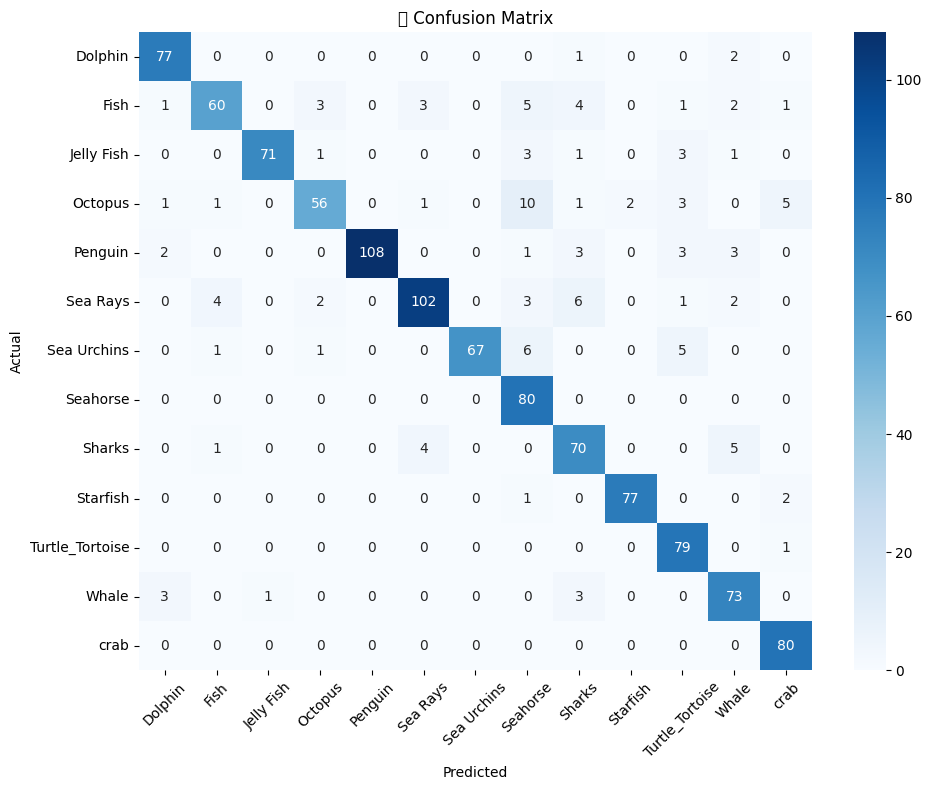

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ✅ Collect all predictions and labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Classification report
class_names = train_dataset.classes
print("\n✅ Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# ✅ Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("✅ Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [17]:
# Collect all predictions and labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# ✅ Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"✅ Accuracy: {accuracy:.4f}")

# ✅ Precision (macro)
precision = precision_score(all_labels, all_preds, average='macro')
print(f"✅ Precision (macro): {precision:.4f}")

# ✅ Recall (macro)
recall = recall_score(all_labels, all_preds, average='macro')
print(f"✅ Recall (macro): {recall:.4f}")

# ✅ F1 Score (macro)
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"✅ F1 Score (macro): {f1:.4f}")

# ✅ Optional: Full report per class
print("\n✅ Detailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_labels))


✅ Accuracy: 0.8929
✅ Precision (macro): 0.8977
✅ Recall (macro): 0.8942
✅ F1 Score (macro): 0.8908

✅ Detailed Classification Report:
                 precision    recall  f1-score   support

        Dolphin       0.92      0.96      0.94        80
           Fish       0.90      0.75      0.82        80
     Jelly Fish       0.99      0.89      0.93        80
        Octopus       0.89      0.70      0.78        80
        Penguin       1.00      0.90      0.95       120
       Sea Rays       0.93      0.85      0.89       120
    Sea Urchins       1.00      0.84      0.91        80
       Seahorse       0.73      1.00      0.85        80
         Sharks       0.79      0.88      0.83        80
       Starfish       0.97      0.96      0.97        80
Turtle_Tortoise       0.83      0.99      0.90        80
          Whale       0.83      0.91      0.87        80
           crab       0.90      1.00      0.95        80

       accuracy                           0.89      1120
      mac

In [19]:
# ✅ Save only the model weights (recommended)
torch.save(model.state_dict(), "/content/drive/MyDrive/swin_transformer_weights80.pth")

# ✅ OR: Save the entire model (less common, not recommended for long term)
# torch.save(model, "/content/drive/MyDrive/swin_transformer_model.pth")


In [20]:
import timm
import torch

# ✅ Create the same model architecture
num_classes = 13  # <-- set this to your number of classes
model = timm.create_model('swin_base_patch4_window7_224', pretrained=False, num_classes=num_classes)

# ✅ Load the saved weights
model.load_state_dict(torch.load("/content/drive/MyDrive/swin_transformer_weights80.pth"))

# ✅ Move to device
model = model.to(device)
model.eval()

print("✅ Swin Transformer model loaded successfully!")


✅ Swin Transformer model loaded successfully!


✅ Predicted Class: Turtle_Tortoise


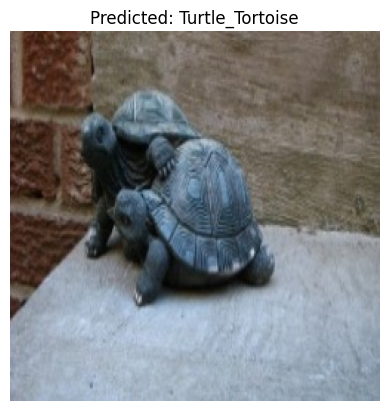

In [16]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# ✅ Use same class labels from training dataset
class_labels = train_dataset.classes

# === Function to predict single image ===
def predict_single_image(img_path, model, class_labels, device, target_size=(224, 224)):
    # 1️⃣ Load image
    img = Image.open(img_path).convert('RGB')

    # 2️⃣ Preprocess: same as training
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

    # 3️⃣ Predict
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted_idx = torch.max(output, 1)
        predicted_class = class_labels[predicted_idx.item()]

    # 4️⃣ Print & Show
    print(f"✅ Predicted Class: {predicted_class}")

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

# === Example usage ===
img_path = '/content/drive/MyDrive/dataset80/80-20/test/Turtle_Tortoise/Turtle_Tortoise (1692).jpg'
predict_single_image(img_path, model, class_labels, device)
